### Example code for Remote Python Pizza Hamburg 2021
### https://github.com/mborus/python_pizza_2021
## "I can show you that on a map"
### Martin Borus (@mborus)


### Updated in 2025 for new H3 syntax. Tested on Python3.13, not working (installabl yet on 3.14/Windows

In [51]:
import pandas as pd
import numpy as np
import locale

In [2]:
import pgeocode
import h3

In [5]:
import geopandas as gpd
import folium
import branca.colormap as cm
from shapely.geometry import Point
from shapely.geometry import Polygon


## Example for pgeocode

In [6]:
# If you have SSL Error: On windows, update Let's Encrypt Root Cert or patch pgeocode
# note: needs: context=ssl._create_unverified_context()) 
# in line 141 of pgeocode.py
# Note: This library creates a "pgeocode" folder in your home directory

nomi = pgeocode.Nominatim('DE')

nomi.query_postal_code(['24937', '25980'])[
    ['postal_code','country_code', 'place_name', 'latitude', 'longitude', 'accuracy']]


,postal_code,country_code,place_name,latitude,longitude,accuracy
0,24937,DE,Flensburg,54.786200,9.4306,4.0
1,25980,DE,"Rantum, Westerland, Sylt-Ost",54.871567,8.3360,4.0


## Example for H3

In [7]:
# Flensburg

H3_RESOLUTION = 5

h3_string = h3.latlng_to_cell(54.7862 ,9.4306, H3_RESOLUTION)

h3_string

'851f3177fffffff'

In [9]:
h3.cell_to_boundary(h3_string)

((54.87004046378098, 9.371420013736126),
 (54.79381950102444, 9.38261483758399),
 (54.76746529083498, 9.513784224260247),
 (54.81730320160282, 9.634048551476893),
 (54.89356108930263, 9.623148495706303),
 (54.91994430460954, 9.491688921177264))

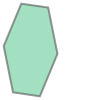

In [10]:
Polygon(h3.cell_to_boundary(h3_string))

# Full 3 step map creating example

In [11]:
# run example
df = pd.read_csv('sample_turnover_germany.csv', sep='|', encoding='utf-8',  dtype='str')

# set comma & thousands decimals correct according to data source
locale.setlocale(0, 'US')
df['turnover(EUR)'] = df['turnover(EUR)'].map(locale.atof)

In [12]:
# show some of the imported lines
df.sample(5)

,zipcode,country,turnover(EUR)
9652,33613,DE,5837.26
4631,90571,DE,704.90
4247,34247,DE,42.41
3637,91614,DE,77.49
2125,57074,DE,2950.50


In [24]:
def step1_geocoding(df):
    # series: group by zipcode, sum the turnover 
    s_zipcode = df.groupby('zipcode')['turnover(EUR)'].sum()
    
    # receive geodata dataframe from pgeocode
    df_geometry = nomi.query_postal_code(list(s_zipcode.index))[['longitude', 'latitude']]
    
    # add column zipcode, turnover 
    df_geometry['zipcode'] = s_zipcode.index
    df_geometry['turnover(EUR)'] = s_zipcode.values
    
    return df_geometry
    

In [122]:
def step2_h3(df):
    
    H3_RESOLUTION = 5
    def lat_lng_to_h3(row):
        # if pd.notna(row.latitude) and pd.notna(row.longitude):
        try:
            return h3.latlng_to_cell(row.latitude,row.longitude, H3_RESOLUTION)
        except Exception:    
            return None
    
    def add_geometry(row):
        boundary = h3.cell_to_boundary(row['h3'])
        polygon = Polygon([(lng, lat) for lat, lng in boundary])
        return polygon
    
    df['h3'] = df.apply(lat_lng_to_h3, axis=1)
    
    df_h3_grouped = df.groupby(['h3'])['turnover(EUR)'].sum().to_frame('turnover(EUR)').reset_index()
    
    # watch out for data that couldn't get h3 encoded, it's in row 0
    df_h3_grouped = df_h3_grouped.iloc[1:].copy()
    df_h3_grouped['geometry'] = df_h3_grouped.apply(add_geometry, axis=1)
    return df_h3_grouped
    

In [132]:
def step3_create_gfd(df, save):
    MAX_AMOUNT_COLORMAP = 100_000
    
    gdf = gpd.GeoDataFrame(df, crs='EPSG:4326')
  
    m = gdf.explore(
        column='turnover(EUR)',
        cmap='YlOrRd',
        vmin=0,
        vmax=MAX_AMOUNT_COLORMAP,
        tiles="cartodbpositron",
        location=[50.523, 9],
        zoom_start=6,
        style_kwds={
            'fillOpacity': 0.7,
            'stroke': False          
        },
        tooltip=['turnover(EUR)'],
        legend=True
    )
    
    if save:
        m.save(f"saved_map.html")

    return m

In [133]:
df1 = step1_geocoding(df)
df2 = step2_h3(df1)
m = step3_create_gfd(df2, save=False)

In [134]:
# show the map!
m